
# Transformer Summarizer (Transformer Özetleyici)

Grup üyeler:
Yapay Zeka 1. Öğretim A grubu
- B201210556 - Muhammad Najmuddin Farid
- B181210568 - Zidan Omar Hamid
- B181210552 - Muhammad Fauzan Asyraf Syahputra

Bu Jupyter Notebook üzerinde insanlar arasındaki konuşmaları özetlemek için basit bir transformer kullanılmaktadır

- `Algoritma adi` : Transformer Özetleyici (Transformer Summarizer)
- `Dataset adı` : SAMSum Corpus: A Human-annotated Dialogue Dataset for Abstractive Summarization [SAMSum Corpus](https://paperswithcode.com/paper/samsum-corpus-a-human-annotated-dialogue-1)
- `Örnek adresi` : [Dataset](https://drive.google.com/file/d/1-NgPkTbkjg_W0xi7Jhvwzf-GxWZhZhkR/view?usp=sharing)
- `Github Link` : https://github.com/faridnec/transformer-summarizer

<a name='0'></a>
## Giriş

Otomatik özetleme genellikle belirli bir veri kümesini bilgisayarla özetleyerek, orijinal veriden en önemli ve ilgili bilgileri temsil eden yeni bir veri kümesi üretme süreci olarak tanımlanır. Metin verileri için, bu özellikle özetin en önemli cümleleri, metin parçacıkları veya kelimeleri içermesi anlamına gelir (Torres-Moreno, 2014). Bir metin özeti mümkünse tutarlı, özlü ve akıcı olmalıdır.
    
Tekrarlayan sinir ağları (Recurrent neural networks), özellikle uzun kısa süreli bellek (long short-term memory) ve kapılı tekrarlayan sinir ağları (gated recurrent neural network), dil modelleme ve makine çevirisi gibi dizi modelleme ve transdüksiyon problemlerinde en gelişmiş yaklaşımlar olarak sağlam bir şekilde oluşturulmuştur. Günümüze kadar, yinelenen dil modellerinin ve kodlayıcı-kod çözücü mimarilerinin sınırlarını zorlamaya yönelik çok sayıda çaba devam etmektedir.
Bu çalışmada, Doğal Dil İşleme (NLP) görevlerinde, özellikle metin özetlemede, önemli ölçüde daha fazla paralelleştirmeye izin veren ve yeni bir teknoloji düzeyine ulaşabilen bir model mimarisi olan Transformer'ı sunulmaktadır.

## Tanım

Transforer, tekrarlayan veya evrişimsel katmanlara dayanmadan sıralı verileri işleyebilen bir sinir ağı türüdür. Bunun yerine, her adımda girdinin ve çıktının en ilgili kısımlarına odaklanmalarını sağlayan attention adı verilen bir mekanizma kullanırlar. Attention aynı zamanda dönüştürücülerin doğal dili anlamak için gerekli olan uzun menzilli bağımlılıkları ve bağlamsal bilgileri yakalamasını sağlar. Dönüştürücüler iki ana bileşenden oluşur: bir kodlayıcı ve bir kod çözücü. Kodlayıcı girdi metnini alır ve onu gömme adı verilen bir dizi gizli temsile dönüştürür. Kod çözücü katıştırmaları alır ve her seferinde bir belirteç olmak üzere çıktı metnini oluşturur.

Metni dönüştürücülerle özetlemek için eğitim, haber makaleleri ve manşetler veya bilimsel makaleler ve özetler gibi geniş bir metin-özet çiftleri topluluğunun kullanılmasını içerir. Eğitim hedefi, çapraz entropi gibi bir kayıp fonksiyonu kullanarak oluşturulan özet ile referans özeti arasındaki eşitsizliği en aza indirmeyi amaçlamaktadır. Çıkarım sırasında, özetlenecek metin kodlayıcıya beslenir ve ardından özeti oluşturmak için kod çözücü kullanılır. Bu, örnekleme yoluyla veya her adımda en olası jetonun seçilmesiyle başarılabilir. Ek olarak, çeşitli potansiyel özetleri takip eden ve puanlama fonksiyonuna göre en iyisini seçen, ışın arama(beam search) adı verilen bir teknik kullanılabilir.

Bu proje üzerinde insanlar arasındaki konuşmaları özetlemek için basit bir transformatör kullanılmaktadır.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import utils
from transformer.utils import *

import textwrap
wrapper = textwrap.TextWrapper(width=70)

tf.keras.utils.set_random_seed(10)

<a name='1'></a>
<!-- ## 1 - Import the Dataset -->

## 1 - Veri Setinin İçe Aktarılması

In [3]:
data_dir = "data/corpus"

train_data, test_data = utils.get_train_test_data(data_dir)

example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue:\n{example_dialogue}")
print(f"\nSummary:\n{example_summary}")

Dialogue:
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary:
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


<a name='2'></a>
## 2 - Veri Ön İşleme

Veri ön işleme sırasında girdi verilerini işlemek üzere tasarlanmıştır. Bu aşamada iki ana girdi alıınmaktadır: "summary" (özet) ve "dialogue" (diyalog). Öncelikle, metin verilerini küçük harflere dönüştürerek bir standart sağlar. Ardından, yeni satırları ve çift boşlukları kaldırarak metnin düzenini iyileştirir. Son olarak, her metin başına bir "[SOS]" (Başlangıç) ve her metin sonuna bir "[EOS]" (Bitiş) işareti ekleyerek, metinlerin başlangıç ve sonunu belirtir. Bu işlemler, metinlerin işlenmesi ve standartlaştırılması için önemli adımları temsil eder, böylece daha tutarlı ve işlenebilir veri elde edilir. Bu ön işleme adımları, metin verilerinin daha iyi analiz edilmesini ve modellemesini sağlar, böylelikle nihai çıktıların kalitesini artırır.

In [4]:
document, summary = utils.preprocess(train_data)
document_test, summary_test = utils.preprocess(test_data)

Tensorflow kütüphanesi ile standart ön işleme; Belgelerdeki ve özetlerdeki verileri birleştirerek ve `.fit_on_texts()` kullanarak kelime dağarcığını oluşturulmaktadır:

<!-- standard preprocessing with the tensorflow library. Create the vocabulary by combining the data in the documents and the summaries and using `.fit_on_texts()`: -->

In [5]:
filters = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n'
oov_token = '[UNK]'

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token, lower=False)

documents_and_summary = pd.concat([document, summary], ignore_index=True)

tokenizer.fit_on_texts(documents_and_summary)

inputs = tokenizer.texts_to_sequences(document)
targets = tokenizer.texts_to_sequences(summary)

vocab_size = len(tokenizer.word_index) + 1

print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


Eğitim verileri için tokenize edilmiş dizilerin doldurulması; Transformer oldukça büyük bir model olduğundan ve bu kadar küçük ortamlarda eğitilmeleri amaçlanmadığından, dizilerin uzunluğu burada sınırlanmaktadır.

In [6]:
encoder_maxlen = 150
decoder_maxlen = 50

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<a name='3'></a>
## 3 - Konumsal Kodlama (Positional Encoding)

Konumsal kodlama, özellikle dizi modellerinde ve özellikle dil modellerinde kullanılan bir tekniktir. Bu teknik, modelin her bir girdi sırasındaki kelimelerin veya öğelerin pozisyonunu temsil etmesini sağlar. Konumsal kodlamalar yerleştirmelerle aynı boyut modeline sahiptir, böylece ikisi toplanabilir. Öğrenilmiş ve sabitlenmiş birçok konumsal kodlama seçeneği vardır.

Hazırlanan fonksiyonda, belirli bir pozisyon ve model boyutuna ${d_model}$ dayalı olarak tüm pozisyonel kodlamaları hesaplar. Bu kodlamalar, bir dizi matematiksel hesaplama kullanılarak önceden hesaplanıp modelin eğitimi sırasında girdi olarak sağlanır. Sonuç olarak, her bir pozisyon için bir vektör oluşturulur. Böylece modelin her bir girdi öğesinin konumunu temsil eder.

Sıralı görevlerde, verilerin göreli sırası anlamı açısından son derece önemlidir. Bir Transformer ağını multi-head attention kullanarak eğittiğimizde, verileri modele tek seferde besleriz. Bu, eğitim süresini önemli ölçüde azaltırken, verilerin sırası hakkında hiçbir bilgi yoktur. Konumsal kodlamanın faydalı olduğu yer burasıdır.

In [7]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings
    """
    
    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2

    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

<a name='4'></a>
## 4 - Maskeleme

Transformer ağı oluştururken yararlı olan iki tür maske vardır: *padding maskesi* ve *look-ahead maskesi*. Her ikisi de softmax hesaplamasının giriş cümlenizdeki kelimelere uygun ağırlıkları vermesine yardımcı olur. 

Dolgu maskesi (Padding mask), özellikle dizi modelleme ve dil işleme gibi görevlerde, girdi dizilerindeki dolgu değerlerini işlemek için kullanılır. Dolgu değerleri, genellikle dizinin sonunda bulunan ve gerçek veri ile ilgili olmayan ekstra değerlerdir. Dolgu maskesi, modelin dikkat mekanizması ve diğer işlemlerinde bu dolgu değerlerini göz ardı etmesine yardımcı olur, böylece modelin doğru sonuçlar üretmesine olanak tanır.

Bakış maskesi (Look ahead mask), çeviri ve benzeri sıralı çıktı problemlerinde kullanılır. Modelin her bir çıktıyı üretirken, daha sonraki çıktıları görmemesini sağlar. Bu, modelin gelecekteki bilgileri kullanmadan, sırayla her bir çıktıyı doğru şekilde tahmin etmesine olanak tanır. Bakış maskesi, modelin zaman boyunca ilerlerken yanlışlıkla gelecekteki bilgilere erişimini önler.

Bu maskeler, modelin daha etkili bir şekilde eğitilmesine ve daha doğru sonuçlar üretmesine yardımcı olur. Dolgu maskesi dolgu değerlerini, bakış maskesi ise gelecekteki bilgileri işlemeden modelin daha doğru sonuçlar üretmesine olanak tanır.

In [8]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    return seq[:, tf.newaxis, :] 


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    
    return mask 

<a name='5'></a>
## 5 - Self Attention

<img src="images/self-attention.png" alt="Self Attention" width="600"/>
<center color='purple'><b>Self Attention</b></center>


Geleneksel evrişimli ağlarla eşleştirilmiş öz dikkat kullanımı, eğitimi hızlandıran paralelleştirmeye izin verir. Bir sorgu, anahtar, değer ve bir maskeyi girdi olarak alan **ölçeklendirilmiş nokta çarpımı dikkati** (**scaled dot product attention**), dizideki kelimelerin zengin, dikkat tabanlı vektör temsillerini döndürür. Transformer'da kullanılan standart dikkat, ölçekli nokta çarpım dikkatidir (Vaswani ve diğerleri, 2017). Giriş, ${d_k}$ boyutundaki sorgulardan ve anahtarlardan ve ${d_v}$ boyutunun değerlerinden oluşur. Sorgunun tüm anahtarlarla nokta çarpımları hesaplanır, ${√min}$ ile ölçeklenir ve değerler üzerindeki ağırlıkları elde etmek için softmax fonksiyonu uygulanır. Uygulamada, bir dizi sorgu üzerindeki dikkat işlevi eş zamanlı olarak hesaplanır ve bir $Q$ matrisinde birlikte paketlenir. Anahtarların ve değerlerin aynı zamanda $K$ ve $V$ matrislerinde birlikte paketlendiğini varsayarsak, çıktı matrisi şu şekilde tanımlanır:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V
$$

* $Q$ sorguların matrisidir (Query)
* $K$ anahtarların matrisidir (Key)
* $V$ değerlerin matrisidir (Value)
* $M$ Maske
* ${d_k}$ anahtarların boyutudur ve softmax'in patlamaması için her şeyi ölçeklendirmek için kullanılır

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None: 
        scaled_attention_logits += (1. - mask) * - 1e9

    attention_weights = tf.keras.activations.softmax(scaled_attention_logits)

    output = tf.matmul(attention_weights, v)

    return output, attention_weights

In [10]:
# Test
q = np.array([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).astype(np.float32)
k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).astype(np.float32)
v = np.array([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).astype(np.float32)
mask = np.array([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = np.around(ou, decimals=2)
atw = np.around(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 [[[1.   0.62]
  [0.62 0.62]
  [0.74 0.31]]]

Attention weigths:
 [[[0.   0.38 0.   0.23 0.38]
  [0.38 0.   0.   0.23 0.38]
  [0.26 0.43 0.   0.16 0.16]]]


<a name='6'></a>
## 6 - Kodlayıcı

<img src="images/encoder_layer.png" alt="Encoder" width="400"/>
<center color='purple'><b>Transformer kodlayıcı katmanı</b></center>

Transformer Kodlayıcı katmanı, eğitim hızını artırmak için öz dikkat ve konvolüsyonel sinir ağı işleme tarzını eşleştirir ve K ve V matrislerini Kod Çözücüye aktarır.

`Multi-head Attention` Transformer'da ${d_model}$ boyutlu anahtarlar, değerler ve sorgular ile tek dikkat fonksiyonunu gerçekleştirmek yerine sorgular, anahtarlar ve değerler ${h}$ kez farklı öğrenilmiş doğrusal projeksiyonlarla sırasıyla ${d_k}$, ${d_k}$ ve ${d_v}$ boyutlarına doğrusal olarak yansıtılır. Sorguların, anahtarların ve değerlerin bu öngörülen sürümlerinin her birine paralel olarak dikkat uygulanarak ${d_v}$ boyutlu çıktı değerleri elde edilir. Bunlar birleştirilip bir kez daha yansıtılarak nihai değerler elde edilir. Bu mekanizmaya çok kafalı dikkat adı verilmektedir.

* Farklı özellikleri tespit etmek için öz dikkati birkaç kez hesaplayan `MultiHeadAttention`. 
* İleri beslemeli sinir ağı, `FullyConnected` işlevine sahip iki Yoğun katman içerir

Giriş cümlesi ilk olarak, kodlayıcının belirli bir kelimeyi kodlarken giriş cümlesindeki diğer kelimelere baktığı bir *çok kafalı dikkat katmanından* geçer. Çok kafalı dikkat katmanının çıktıları daha sonra bir *ileri beslemeli sinir ağına* beslenir. Aynı ileri besleme ağı her pozisyona bağımsız olarak uygulanır.
   
* MultiHeadAttention katmanı için Keras'ta uygulanan [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) kullanılır.
* [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)

In [12]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers.
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])

<a name='6-1'></a>
### 6.1 Kodlayıcı Katmanı

Kodlayıcı katmanında, çok kafalı dikkat ve ileri beslemeli sinir ağı birlikte eşleştirilmiştir. Ek olarak, daha hızlı eğitimi kolaylaştırmak için artık bağlantılar ve katman normalizasyonu kullanılır.

1. Q, V, K matrislerini ve bir boolean maskesini çok kafalı bir dikkat katmanına alır.
2. Orijinal `x` girdinizi ve çok kafalı dikkat katmanının çıktısını eklemek için bir atlama bağlantısı vardır. 
3. Atlama bağlantısı eklendikten sonra, çıktı ilk normalleştirme katmanından geçer.
4. Adım 1-3, ileri beslemeli sinir ağı ve çok kafalı dikkat katmanı yerine bir bırakma katmanı ile tekrarlanır.

In [13]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        
        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer

        """

        self_mha_output = self.mha(x, x, x, mask)

        skip_x_attention = self.layernorm1(x + self_mha_output)

        ffn_output = self.ffn(skip_x_attention)

        ffn_output = self.dropout_ffn(ffn_output, training=training)

        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)
        
        return encoder_layer_out

<a name='6-2'></a>
### 6.2 - Tam Kodlayıcı

<img src="images/encoder.png" alt="Encoder" width="250"/>
<center color='purple'><b>Transformer Kodlayıcı</b></center>

Tam Dönüştürücü Kodlayıcı, girdinin gömülmesi ve hesaplanan konumsal kodlamaların dahil edilmesiyle oluşturulur. Daha sonra, kodlanmış gömüler bir Kodlayıcı katmanları yığınından geçirilir.

1. Girdinin Gömme katmanından geçirilmesi.
2. Gömme boyutunun karekökü ile çarpılarak gömmenin ölçeklendirilmesi. 
3. Pozisyon kodlamasının eklenmesi: self.pos_encoding `[:, :seq_len, :]` gömülmeye eklenir.
4. Kodlanmış katıştırmayı bir dropout katmanından geçirilmesi
5. Bırakma katmanının çıktısının bir for döngüsü kullanılarak kodlama katmanları yığınından geçirilmesi.

In [14]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder

        """
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)

        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x 

<a name='7'></a>
## 7 - Dekoder / Kod Çözücü

Kod Çözücü katmanı, Kodlayıcı tarafından üretilen K ve V matrislerini alır ve çıktıdan Q matrisi ile ikinci çok kafalı dikkat katmanını hesaplar

<img src="images/decoder_layer.png" alt="Decoder" width="250"/>
<center color='purple'><b>Transformer Dekoder katmanı</b></center>

### 7.1 - Dekoder Katmanı
    
`DecoderLayer()` metodunun `call()` metodu kullanılarak uygulanması
    
1. Blok 1, artık bağlantısı ve ileriye bakma maskesi olan çok kafalı bir dikkat katmanıdır. Kodlayıcı Katmanı'nda olduğu gibi, Dropout çok kafalı dikkat katmanı içinde tanımlanır.
2. Blok 2, Kodlayıcının çıktısını dikkate alacaktır, bu nedenle çok kafalı dikkat katmanı kodlayıcıdan K ve V'yi ve Blok 1'den Q'yu alacaktır.
3. Blok 3, dropout, normalleştirme katmanları ve residual connection sahip ileri beslemeli bir sinir ağıdır.

Burada, iki çok kafalı dikkat katmanı, kodlayıcı katmanında ileri beslemeli bir sinir ağı ile eşleştirilmiştir. Eğitimi hızlandırmak için artık bağlantılar ve katman normalizasyonu kullanılır.

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        """
        
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True) 
        
        Q1 = self.layernorm1(x + mult_attn_out1)

        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, padding_mask, return_attention_scores=True)

        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)

        ffn_output = self.ffn(mult_attn_out2)

        ffn_output = self.dropout_ffn(ffn_output, training=training)

        out3 = self.layernorm3(ffn_output + mult_attn_out2)

        return out3, attn_weights_block1, attn_weights_block2

<a name='7-2'></a>
### 7.2 - Tam Dekoder

Çıktı gömülür ve konumsal kodlamalar eklenir. Kodlanmış gömüler daha sonra bir Kod Çözücü katmanı yığınına beslenir.

<img src="images/decoder.png" alt="Decoder" width="250"/>
<center color='purple'><b>Transformer Dekoder</b></center>

`Decoder()`, çıktıyı gömmek, konumsal kodlama eklemek ve birden fazla kod çözücü katmanı çalıştırmak için `call()` yöntemi kullanılarak uygulanır. Kod Çözücü bir Gömme katmanı, konumsal kodlama ve birkaç `DecoderLayers` ile başlatılır. `call()` yönteminde aşağıdaki adımlar gerçekleştirilir:

1. Üretilen çıktı Gömme katmanından geçirilir.
2. Gömme, gömme boyutunun karekökü ile çarpılarak ölçeklendirilir; gömme boyutu, karekök hesaplanmadan önce `tf.float32` veri türüne dönüştürülür.
3. Gömmeye konum kodlaması eklenir: self.pos_encoding `[:, :seq_len, :]`.
4. Kodlanmış gömme, eğitim parametresi tarafından ayarlanan model eğitim modu ile bir bırakma katmanından geçirilir.
5. Bırakma(Dropout) katmanının çıktısı, bir for döngüsü kullanılarak Kod Çözme katmanları yığınından geçirilir.

In [31]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)

        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):

            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2

        return x, attention_weights

## 8 - Transformer

<img src="images/transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Görsel: Örnek Transformer</font></center></caption>

Transformer Mimarisi boyunca veri akışı aşağıdaki gibidir:

* İlk olarak, girdi tekrarlanan Kodlayıcı katmanlarından oluşan bir Kodlayıcıdan geçirilir:
    - Girdinin gömülmesi ve konumsal kodlaması gerçekleştirilir.
    - Girişe çok kafalı dikkat (Multi-head Attention) uygulanır.
    - Özellikler ileri beslemeli bir sinir ağı kullanılarak tespit edilir.
* Ardından, tahmin edilen çıktı, kod çözücü katmanlarından oluşan bir Kod Çözücüden geçirilir:
    - Çıktının gömülmesi ve konumsal kodlaması gerçekleştirilir.
    - Üretilen çıktıya çok kafalı dikkat uygulanır.
    - Çok kafalı dikkat, ilk çok kafalı dikkat katmanından gelen Q ve Kodlayıcıdan gelen K ve V kullanılarak gerçekleştirilir.
    - Özellikler ileri beslemeli bir sinir ağı kullanılarak tespit edilir.
* Son olarak, N. Kod Çözücü katmanından sonra, dizideki bir sonraki çıktı için tahminler oluşturmak üzere bir yoğun katman ve bir softmax uygulanır.

`Transformer()`, `call()` metodu kullanılarak aşağıdaki gibi uygulanır:

1. Giriş, uygun maske ile Kodlayıcıdan geçirilir.
2. Kodlayıcı çıkışı ve hedef, uygun maske ile Kod Çözücüden geçirilir.
3. Bir tahmin elde etmek için doğrusal bir dönüşüm ve bir softmax uygulanır.

In [40]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        
        """
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

<a name='9'></a>
## 9 - Modelin Başlatılması

Model aşağıdaki parametrelerle başlatılır. Bu modellerin çok daha büyük olduğunu belirtmek gerekir, ancak bu ortama uyması ve sadece birkaç dakika içinde eğitime olanak sağlaması için burada daha küçük bir versiyon kullanılmıştır.

Orijinal Transformer makalesinde açıklanan temel modelde `num_layers=6`, `embedding_dim=512` ve `fully_connected_dim=2048` kullanılmıştır.

In [43]:
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

<a name='10'></a>
## 10 - Modeli Eğitmek için Hazırlık

Aşağıdaki hücrede tanımladığımız özel öğrenme oranı zamanlamasına sahip Adam optimizer kullanmaktadır.

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(embedding_dim)

optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

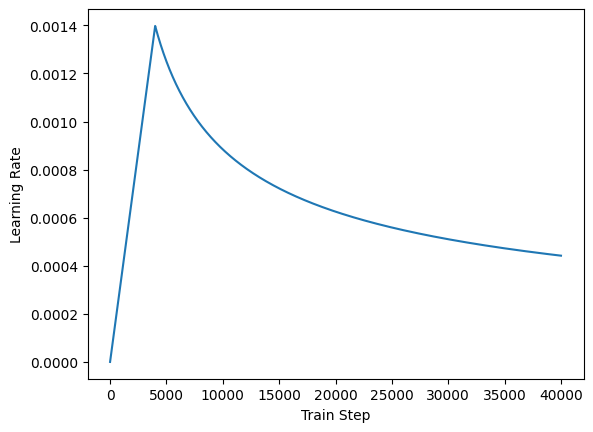

In [45]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

Kayıp, seyrek kategorik çapraz entropi (sparse categorical cross-entropy) kayıp fonksiyonu `(tf.keras.losses.SparseCategoricalCrossentropy)` kullanılarak ayarlanır.

Son katman softmax aktivasyonuna sahip olduğu için Transformer ham logit çıktısı vermediğinden `from_logits` parametresi False olarak ayarlanmıştır. Ayrıca, dolgulu hedef dizileri hesaba katmak için kayıp hesaplanırken bir dolgu maskesi uygulanır.

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def masked_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')

losses = []

Özel eğitim fonksiyonu, model.compile() ve model.fit() kullanımına alternatif olarak daha fazla esneklik sunmak için tanımlanmıştır.

In [47]:
@tf.function
def train_step(model, inp, tar):
    """
    One training step for the transformer

    """
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = create_padding_mask(inp)

    with tf.GradientTape() as tape:
        predictions, _ = model(
            inp,
            tar_inp, 
            True, 
            enc_padding_mask, 
            look_ahead_mask, 
            dec_padding_mask
        )
        loss = masked_loss(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

<a name='11'></a>
## 11 - Özetleme

Bu bölümde, açgözlü kod çözme adı verilen basit bir yöntem kullanılarak belgelerin gerçek özetlerini üretmek için çıkarım uygulanır. Bu, her seferinde bir kelimenin tahmin edilmesini ve çıktıya eklenmesini içerir. İşlem bir [SOS] belirteci ile başlar ve model [EOS] belirtecini döndürene veya cümlenin maksimum uzunluğuna ulaşana kadar kelime kelime devam eder. Bu sınırın eklenmesi, iyi eğitilmemiş bir modelin [EOS] belirtecini üretmeden sonsuz cümle üretmesini önlemek için gereklidir.

In [49]:
# Take a random sentence as an input
input_document = tokenizer.texts_to_sequences(["a random sentence"])
input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
encoder_input = tf.expand_dims(input_document[0], 0)

output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)

predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.sequences_to_texts(predicted_token.numpy())[0]
print(f"Predicted word: {predicted_word}")

Predicted token: [[14859]]
Predicted word: masses


In [51]:
def summarize(model, input_document):
    """
    A function for summarization using the transformer model

    """    
    input_document = tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = tf.expand_dims(input_document[0], 0)
    
    output = tf.expand_dims([tokenizer.word_index["[SOS]"]], 0)
    
    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = tf.concat([output, predicted_id], axis=-1)
        
        if predicted_id == tokenizer.word_index["[EOS]"]:
            break

    return tokenizer.sequences_to_texts(output.numpy())[0]

Burada özetleme yapabiliriz, ancak model henüz eğitilmediğinden, sadece anlamlı olmayan bir özet üretecektir

In [52]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] masses kindergarten concept kindergarten concept bloomer wilingness sux sam kindergarten lisabeth kindergarten sawyer's sawyer's masses concept bloomer lisabeth bloomer wilingness 80000 bt hotsummer hoax hoax kieslowski wilingness 80000 dont't elis' 🐶❤️👍 cots saaaad evelynn inexperienced suji zubac forthcoming callum farmers extraordinary callum kindergarten worthy extraordinary readable 🐶❤️👍 thinkgn 🐶❤️👍 cots"

<a name='12'></a>
# 12 - Modelin eğitilmesi


Model 20 epokluk bir döngü kullanılarak eğitilir. Her epoktan sonra, model test setinden bir cümle üzerinde özetleme gerçekleştirir ve modelin gelişimini gözlemlemek için sonuç yazdırılır.

In [53]:
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]

epochs = 20

for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        train_step(transformer, inp, tar)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    print('Example summarization on the test set:')
    print('  True summarization:')
    print(f'    {true_summary}')
    print('  Predicted summarization:')
    print(f'    {summarize(transformer, true_document)}\n')

Epoch 1, Loss 7.886631
Time taken for one epoch: 68.23813128471375 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] [EOS]

Epoch 2, Loss 6.600131
Time taken for one epoch: 24.56871461868286 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summarization:
    [SOS] is going to the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Epoch 3, Loss 6.029431
Time taken for one epoch: 16.715919256210327 sec
Example summarization on the test set:
  True summarization:
    [SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]
  Predicted summariza

Kayıp fonksiyonunun çizilmesi.

Text(0.5, 0, 'Epoch')

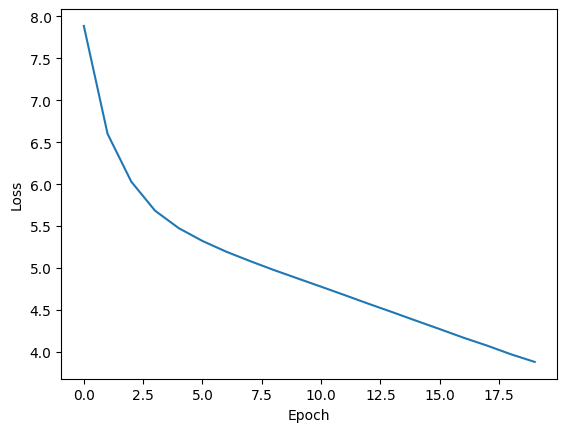

In [54]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Özet
İşte hem eğitim hem de test setlerinden cümlelerin bir özeti:

In [55]:
training_set_example = 0

print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:
[SOS] amanda will bring some cookies [EOS]


In [56]:
test_set_example = 3

print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:
[SOS] emma will pick up with emma at home tonight [EOS]


# Değerlendirme

Modelin çıktısını incelersek, birkaç şey fark edebiliriz:

- Eğitim sırasında, modelin çıktısı birkaç epoktan sonra bile gerçek çıktı ile yakından eşleşir. Bunun nedeni, eğitim verilerinin küçük ve modelin büyük olması, eğitim cümlelerini gerçekten anlamak yerine ezberlemesine neden olabilir, bu da aşırı uyum olarak bilinir.

- Model eğitim verilerinde iyi performans göstermesine rağmen, test verilerindeki performansı o kadar iyi değildir. Eğitim verilerine aşırı uyum sağlar ancak yeni verilere genelleme yapmakta zorlanır. Bunun için sıklıkla belirtilen bir neden, eğitim verilerinin modelin karmaşıklığına kıyasla nispeten küçük olmasıdır. Ancak, başka faktörlerin de rol oynayabileceğini kabul etmek önemlidir.

Test seti örneği 3 ve özeti göz önünde bulundurulduğunda, veriler bazen net olmayabilir ve bu da nasıl özetlendiğini etkileyebilir. Ayrıca, model eğitiminin etkinliği veri setinin kalitesine bağlıdır. Bu durumda, öğrenmenin sınırlı bir ortamda gerçekleşebileceğini göstermek için küçük bir veri kümesi kullanılır.

# Kaynaklar

B. Gliwa, I. Mochol, M. Biesek, A. Wawer. "SAMS um Corpus: A Human-annotated Dialogue Dataset for Abstractive Summarization." In Proceedings of the 2nd Workshop on New Frontiers in Summarization, Hong Kong, China, Nov. 2019. Association for Computational Linguistics. [Online]. https://www.aclweb.org/anthology/D19-5409.

Jay Alammar. "The Illustrated Transformer." [Online]. https://jalammar.github.io/illustrated-transformer/

J.-M. Torres-Moreno. "Automatic Text Summarization." 2014.

C. Kathri, G. Singh, N. Parikh. "Abstractive and Extractive Text Summarization using Document Context Vector and Recurrent Neural Networks." 2018.

Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, Yann N. Dauphin. "Convolutional Sequence to Sequence Learning." arXiv:1705.03122v2, 2017.

Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. "Attention is All You Need." CoRR, 2017. [Online]. http://arxiv.org/abs/1706.03762